In [1]:
import numpy as np # Alg. Lin.
import pandas as pd # Process. Dados
%matplotlib inline
import matplotlib.pyplot as plt  # Gráficos
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew # Para ver as estatísticas
from sklearn.preprocessing import LabelEncoder # sklearn para Machine Learning
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from pylab import savefig

In [2]:
# Puxar os dados aqui
np.random.seed(0)
train = pd.read_excel("C:/Users/C339182/Downloads/BD_COMPETITION_VALORES.xlsx",index_col=0,header=0)
train.head(5)

,Sexo,Idade,Modalidade,Turno,Idade do plano,Renda familiar,Renovacao,Profissao,Acesso a outras unidades,N absoluto de reclamacoes
ID,,,,,,,,,,
1,F,59,M,MANHA,8,25535,Semestral,Engenheiro,NAO,1
2,F,66,NL,NOITE,21,14187,Anual,Empresario,NAO,0
3,M,35,MN,MANHA,74,19156,Anual,Empresario,NAO,0
4,F,52,N,NOITE,25,11737,Semestral,Arquiteto,NAO,0
5,M,24,MNL,MANHA,23,10474,Semestral,Comerciante,NAO,0


In [3]:
train['Sexo'].value_counts()

F    897
M    777
Name: Sexo, dtype: int64

The shape is (1674, 10)


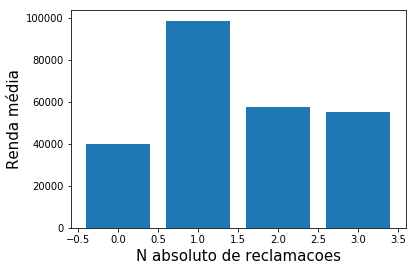

In [4]:
# Verificar outliers
print("The shape is {}".format(train.shape))

fig, ax = plt.subplots()
ax.bar(height = train['Renda familiar'], x = train['N absoluto de reclamacoes'])
plt.ylabel('Renda média', fontsize=15)
plt.xlabel('N absoluto de reclamacoes', fontsize=15)

plt.savefig("Hist_OO.png", dpi=fig.dpi, transparent=True)

plt.show()

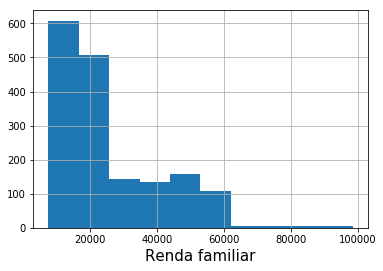

In [5]:
train['Renda familiar'].hist(bins=10)
plt.xlabel('Renda familiar', fontsize=15)

plt.savefig("Renda_OO.png", dpi=fig.dpi, transparent=True)

In [6]:
print('Quantidades de reclamações por quantidades')
print(train['N absoluto de reclamacoes'].value_counts(normalize = True))
print('\n')

Quantidades de reclamações por quantidades
0    0.757467
1    0.237754
3    0.002389
2    0.002389
Name: N absoluto de reclamacoes, dtype: float64




In [7]:
# Target variable: quantidade de reclamações
# Fazer algumas distribuições pra ver a necessidade de padronizar dados. Padronizar por min-max se necessário. Ou log.
print('Quantidades de reclamações das mulheres')
print(train['N absoluto de reclamacoes'][train['Sexo']=='F'].value_counts(normalize = True))
print('\n')

Quantidades de reclamações das mulheres
0    0.764771
1    0.230769
3    0.002230
2    0.002230
Name: N absoluto de reclamacoes, dtype: float64




In [8]:
print('Quantidades de reclamações dos homens')
print(train['N absoluto de reclamacoes'][train['Sexo']=='M'].value_counts(normalize = True))
print('\n')

Quantidades de reclamações dos homens
0    0.749035
1    0.245817
3    0.002574
2    0.002574
Name: N absoluto de reclamacoes, dtype: float64




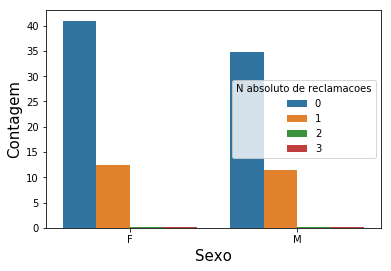

In [9]:
sns.barplot(x='Sexo',y='Idade do plano',hue='N absoluto de reclamacoes',data=train, estimator=lambda x: len(x) / len(train) * 100)
plt.xlabel('Sexo', fontsize=15)
plt.ylabel('Contagem', fontsize=15)

plt.savefig("Reclamacao_Sexo.png", dpi=100, transparent=True)

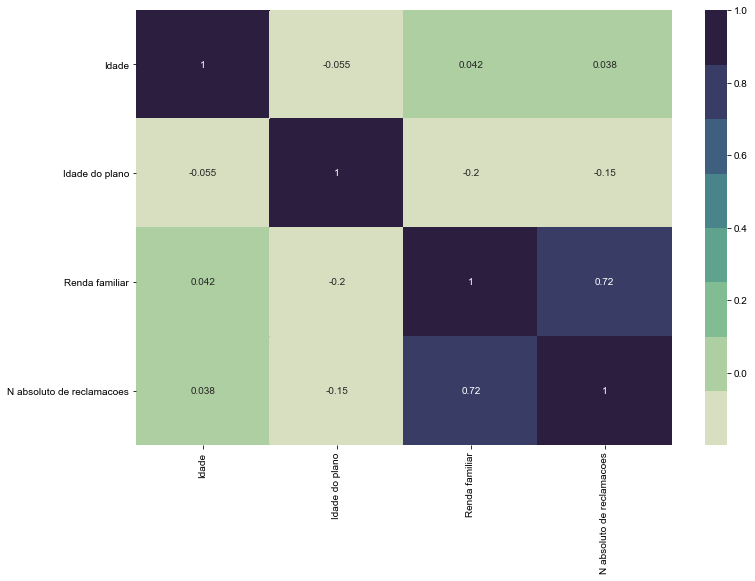

In [10]:
# Heatmap de correlações
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(), cmap = sns.cubehelix_palette(8, start=.5, rot=-.75), annot=True)
sns.set(font_scale=1.5)

plt.yticks(rotation=0)
plt.xticks(rotation=90)

y_train = train["N absoluto de reclamacoes"].values
plt.savefig("Heatmap_OO.png", dpi=400, transparent=True, bbox_inches = 'tight') # bbox_inches salva todo o graf sem cortar labels

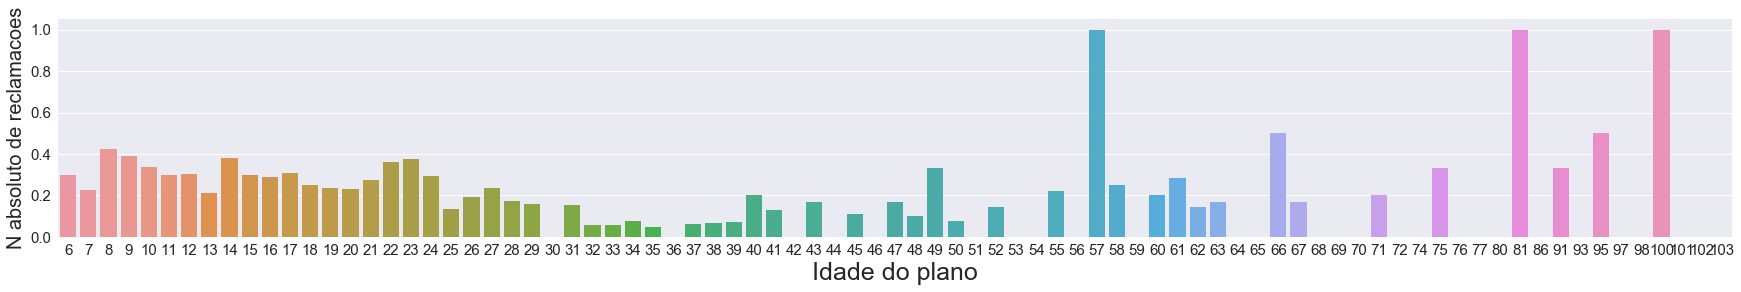

In [11]:
fig, axis1 = plt.subplots(1,1,figsize=(30,4))
average_age = train[["Idade do plano", "N absoluto de reclamacoes"]].groupby(['Idade do plano'],as_index=False).mean()
sns.barplot(x='Idade do plano', y='N absoluto de reclamacoes', data=average_age)
plt.xlabel('Idade do plano', fontsize=25)
plt.ylabel('N absoluto de reclamacoes', fontsize=20)

plt.savefig("Idade_plano_OO.png", dpi=fig.dpi, transparent=True, bbox_inches = 'tight')

C:\Users\C339182\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\C339182\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\C339182\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\C339182\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' 

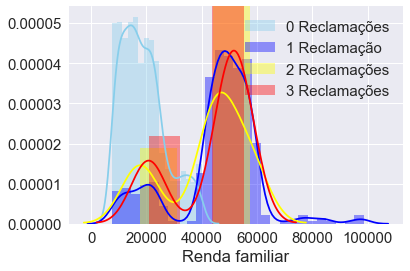

In [12]:
sns.distplot( train["Renda familiar"][train["N absoluto de reclamacoes"]==0] , color="skyblue", label="0 Reclamações")
sns.distplot( train["Renda familiar"][train["N absoluto de reclamacoes"]==1] , color="blue", label="1 Reclamação")
sns.distplot( train["Renda familiar"][train["N absoluto de reclamacoes"]==2] , color="yellow", label="2 Reclamações")
sns.distplot( train["Renda familiar"][train["N absoluto de reclamacoes"]==3] , color="red", label="3 Reclamações")

plt.legend()

C:\Users\C339182\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\C339182\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\C339182\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\C339182\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' 

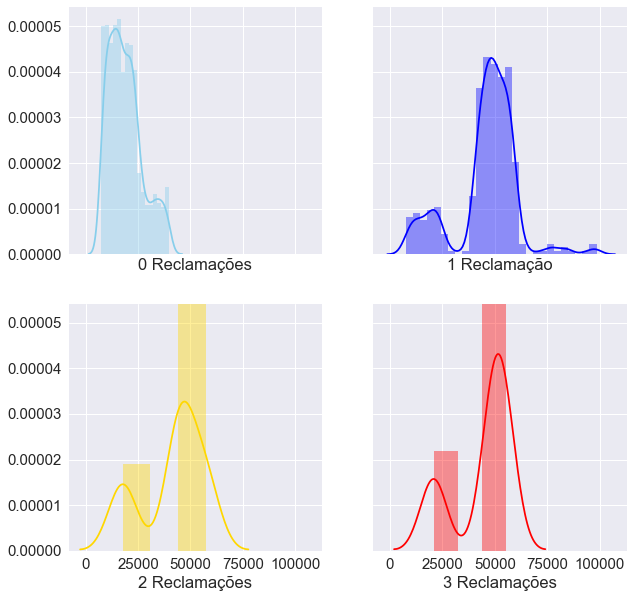

In [13]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

sns.distplot( train["Renda familiar"][train["N absoluto de reclamacoes"]==0] , color="skyblue", ax=axes[0, 0],
             label = "0 Reclamações", axlabel="0 Reclamações")
sns.distplot( train["Renda familiar"][train["N absoluto de reclamacoes"]==1] , color="blue", ax=axes[0, 1],
             label = "1 Reclamação", axlabel="1 Reclamação")
sns.distplot( train["Renda familiar"][train["N absoluto de reclamacoes"]==2] , color="gold", ax=axes[1, 0], 
             label = "2 Reclamações", axlabel="2 Reclamações")
sns.distplot( train["Renda familiar"][train["N absoluto de reclamacoes"]==3] , color="red", ax=axes[1, 1], 
             label = "3 Reclamações", axlabel="3 Reclamações")

plt.savefig("Reclamacao_Renda.png", dpi=150, transparent=True)

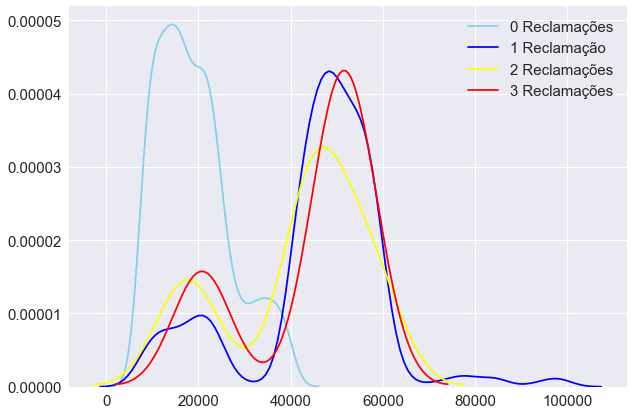

In [14]:
# Closest to original
fig, axis1 = plt.subplots(1,1,figsize=(10,7))

p1=sns.kdeplot(train["Renda familiar"][train["N absoluto de reclamacoes"]==0], shade=False, color="skyblue", label= "0 Reclamações")
p1=sns.kdeplot(train["Renda familiar"][train["N absoluto de reclamacoes"]==1], shade=False, color="blue", label= "1 Reclamação")
p1=sns.kdeplot(train["Renda familiar"][train["N absoluto de reclamacoes"]==2], shade=False, color="yellow", label= "2 Reclamações")
p1=sns.kdeplot(train["Renda familiar"][train["N absoluto de reclamacoes"]==3], shade=False, color="red", label= "3 Reclamações")

plt.legend()

In [15]:
pd.crosstab([train['Sexo'],train['N absoluto de reclamacoes']],train['Modalidade'],margins=True).style.background_gradient(cmap='PuBu')

In [16]:
# LabelEncoder para transformar texto em variável calculavel.
train['Idade do plano'] = train['Idade do plano'].astype(str)
train['Idade'] = train['Idade'].astype(str)

cols = ('Sexo', 'Modalidade', 'Turno', 'Renovacao', 'Profissao', 'Acesso a outras unidades')
for c in cols:
    lbl=LabelEncoder()
    lbl.fit(list(train[c].values))
    train[c] = lbl.transform(list(train[c].values))

print("Shape is {}".format(train.shape))
train.head()

Shape is (1674, 10)


,Sexo,Idade,Modalidade,Turno,Idade do plano,Renda familiar,Renovacao,Profissao,Acesso a outras unidades,N absoluto de reclamacoes
ID,,,,,,,,,,
1,0,59,1,0,8,25535,1,6,0,1
2,0,66,6,1,21,14187,0,5,0,0
3,1,35,3,0,74,19156,0,5,0,0
4,0,52,5,1,25,11737,1,1,0,0
5,1,24,4,0,23,10474,1,3,0,0


In [17]:
# Get dummies
train = pd.get_dummies(train)
print("New shape is {}".format(train.shape))

New shape is (1674, 151)


In [18]:
# Validation
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [19]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.05, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.05, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.05, kernel='polynomial', degree=2, coef0=2.5)
knn = make_pipeline(RobustScaler(), KNeighborsClassifier(n_neighbors=18))

In [20]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(1-score.mean(), score.std()))


Lasso score: 0.8824 (0.0522)



In [21]:
score_ENet = rmsle_cv(ENet)
print("\nElasticNet score: {:.4f} ({:.4f})\n".format(1-score_ENet.mean(), score_ENet.std()))


ElasticNet score: 0.8852 (0.0493)



In [22]:
score = rmsle_cv(KRR)
print("\nKernel Ridge score: {:.4f} ({:.4f})\n".format(1-score.mean(), score.std()))

C:\Users\C339182\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\C339182\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\C339182\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\C339182\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("S


Kernel Ridge score: 0.8210 (0.1252)



In [ ]:
score_knn = rmsle_cv(knn)
print("\nKNN score: {:.4f} ({:.4f})\n".format(1-score_knn.mean(), score_knn.std()))

In [ ]:
# Clusterizando a BD para ajudar visualização

In [ ]:
y = train['N absoluto de reclamacoes'].values
x = train.drop(['N absoluto de reclamacoes'], axis=1).values

In [ ]:
knn = KNeighborsClassifier(n_neighbors=18)
knn.fit(x,y)
y_pred = knn.predict(x)
y_pred_prob = knn.predict_proba(x)

In [ ]:
acc = knn.score(x,y)
acc

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=42, stratify=y)

In [ ]:
knn.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')

plt.tight_layout()
plt.show()

In [ ]:
print(knn.score(X_test, y_test))

In [ ]:
vizinhos = np.arange(1, 100)
train_accuracy = np.empty(len(vizinhos))
test_accuracy = np.empty(len(vizinhos))

for i, k in enumerate(vizinhos):
    knn = KNeighborsClassifier(n_neighbors = k)

    knn.fit(X_train, y_train)
    
    train_accuracy[i] = knn.score(X_train, y_train)

    test_accuracy[i] = knn.score(X_test, y_test)

plt.title('k-NN: Variando Número de Vizinhos')
plt.plot(vizinhos, train_accuracy, label = 'Training Accuracy')
plt.plot(vizinhos, test_accuracy, label = 'Testing Accuracy')
plt.legend()
plt.xlabel('Número de Vizinhos')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
test_accuracy.argmax()

In [ ]:
test_accuracy[18] # é igual ao máximo, só que diminui overfit

In [ ]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.pandas.DataFrame(x_scaled)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.3, random_state=42, stratify=y)

In [ ]:
vizinhos = np.arange(1, 100)
train_accuracy = np.empty(len(vizinhos))
test_accuracy = np.empty(len(vizinhos))

for i, k in enumerate(vizinhos):
    knn = KNeighborsClassifier(n_neighbors = k)

    knn.fit(X_train, y_train)
    
    train_accuracy[i] = knn.score(X_train, y_train)

    test_accuracy[i] = knn.score(X_test, y_test)

plt.title('k-NN: Variando Número de Vizinhos')
plt.plot(vizinhos, train_accuracy, label = 'Training Accuracy')
plt.plot(vizinhos, test_accuracy, label = 'Testing Accuracy')
plt.legend()
plt.xlabel('Número de Vizinhos')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
test_accuracy[22]

In [ ]:
test_accuracy.argmax() # 0.8648111332007953